# Análise Exploratória dos Dados (EDA)

### 1. Introdução ao RAVDESS Dataframe

#### Aqui está um exemplo de um nome de arquivo de áudio conforme descrito no site oficial do RAVDESS:
    - Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    - Vocal channel (01 = speech, 02 = song).
    - Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    - Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
    - Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    - Repetition (01 = 1st repetition, 02 = 2nd repetition).
    - Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

#### Aqui está um exemplo do aúdio 02-01-06-01-02-01-12.mp4. Isso significa que os metadados para esse arquivo de áudio são:
    - Video-only (02)
    - Speech (01)
    - Fearful (06)
    - Normal intensity (01)
    - Statement "dogs" (02)
    - 1st Repetition (01)
    - 12th Actor (12) - Female (as the actor ID number is even)

### 2. Criando um DataFrame sobre os arquivos de áudio do dataset RAVDESS

#### 2.1. Importando as bibliotecas

In [84]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### 2.2. Criando o dataframe

In [85]:
Ravdess = "/Users/iza/Desktop/miniprojeto2/data/Audio_Speech_Actors_01-24"

In [86]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    if os.path.isdir(os.path.join(Ravdess, dir)):
        actor = os.listdir(os.path.join(Ravdess, dir))
        for file in actor:
            if file.endswith(".wav"):
                part = file.split('.')[0]
                part = part.split('-')
                file_emotion.append(int(part[2]))
                file_path.append(os.path.join(Ravdess, dir, file))
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0    angry  /Users/iza/Desktop/miniprojeto2/data/Audio_Spe...
1     fear  /Users/iza/Desktop/miniprojeto2/data/Audio_Spe...
2     fear  /Users/iza/Desktop/miniprojeto2/data/Audio_Spe...
3    angry  /Users/iza/Desktop/miniprojeto2/data/Audio_Spe...
4  disgust  /Users/iza/Desktop/miniprojeto2/data/Audio_Spe...

### 3. Limpeza dos Dados
- Agora que criamos o nosso Dataframe, precisamos nos certificar que ele está limpo de erros e pronto para os próximos passos.

#### 3.1. Verificando se há arquivos corrompidos, muito curtos ou com problemas de leitura

In [87]:
def check_audio_files(df): # Verificando os arquivos de áudio:
    valid_files = []
    invalid_files = []
    for file in df['Path']:
        try:
            audio, sample_rate = librosa.load(file, sr=None)
            if librosa.get_duration(y=audio, sr=sample_rate) < 1.0:
                invalid_files.append(file) # Adicionando arquivos com menos de 1 segundo na lista de inválidos.
            else:
                valid_files.append(file) # Adicionando arquivos válidos (com mais de 1 segundo) na lista de válidos.
        except Exception as e:
            invalid_files.append(file) # Adicionando arquivos corrompidos ou com problema na lista de inválidos.
    return valid_files, invalid_files

valid_files, invalid_files = check_audio_files(Ravdess_df)

Ravdess_df = Ravdess_df[Ravdess_df["Path"].isin(valid_files)] # Mantendo apenas os arquivos válidos no dataframe.

print(f"Arquivos válidos: {len(valid_files)}")
print(f"Arquivos inválidos/removidos: {len(invalid_files)}")

Arquivos válidos: 1440
Arquivos inválidos/removidos: 0


### 4. Exploração e Visualização dos Dados

#### 4.1. Visualizando quais são as principais emoções presentes em nosso dataframe

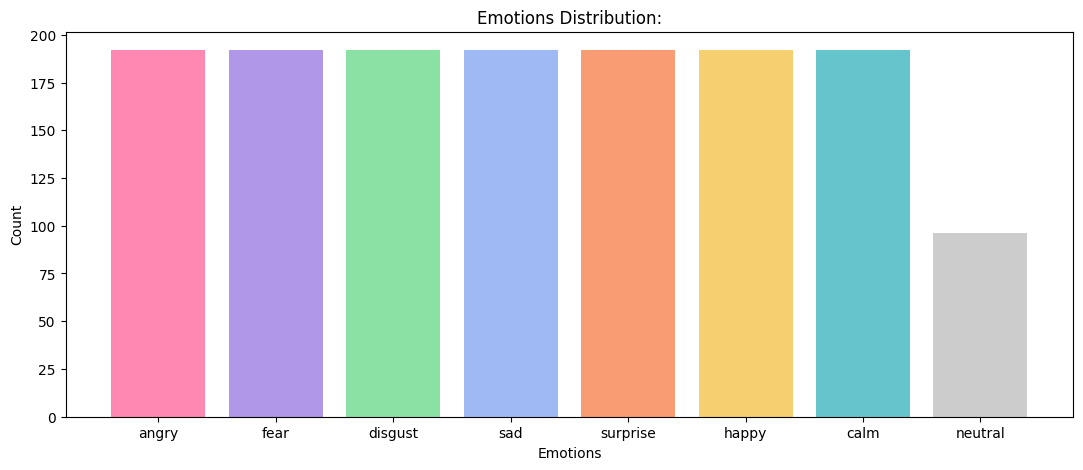

In [88]:
emotion_counts = Ravdess_df['Emotions'].value_counts().reset_index()
emotion_counts.columns = ['Emotions', 'Count']

plt.figure(figsize=(13,5))
plt.bar(
    emotion_counts['Emotions'],
    emotion_counts['Count'],
    color=[
        '#fe88b1','#b097e7', '#8be0a4', '#9eb9f3', '#f89c74', '#f6cf71', '#66c5cc', '#cccccc']
)
plt.title('Emotions Distribution:')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

#### 4.2. Plotando o sinal de aúdio em forma de onda e em espectograma
- Forma de Onda - Os Waveplots nos permitem visualizar a intensidade (volume) do áudio em um determinado momento.
- Espectrogramas - Um espectrograma é uma representação visual do espectro de frequências de um som ou de outros sinais à medida que variam ao longo do tempo. Ele mostra como as frequências mudam em relação ao tempo para um determinado sinal de áudio.

In [89]:
def create_waveplot(data, sr, e): # Criando gráfico de onda para análise dos áudios:

    plt.figure(figsize=(20, 6))
    color = emotion_colors.get(e, '#ff6699')
    
    librosa.display.waveshow(data, sr=sr, color=color)
    plt.title('Gráfico de Onda', fontsize=16)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    
    plt.show()

def create_spectrogram(data, sr, e): # Criando espectrograma para análise dos áudios:
    
    plt.figure(figsize=(20, 6))
    
    S = librosa.stft(data)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', cmap="twilight")
    plt.title('Espectrograma', fontsize=16)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Frequência (Hz)')
    plt.tight_layout()

    plt.show()

# Organizando as cores dos gráficos para cada emoção:
emotion_colors = {
    'angry':   '#CC503E',
    'fear':    '#94346E',  
    'disgust': '#0F8554',
    'sad':     '#1D6996', 
    'surprise':'#EDAD08', 
    'happy':   '#E17C05', 
    'calm':    '#5F4690', 
    'neutral': '#666666' }


####  Exemplos de gráficos de cada uma das emoções presentes no dataset:

#### - Emoção de Raiva

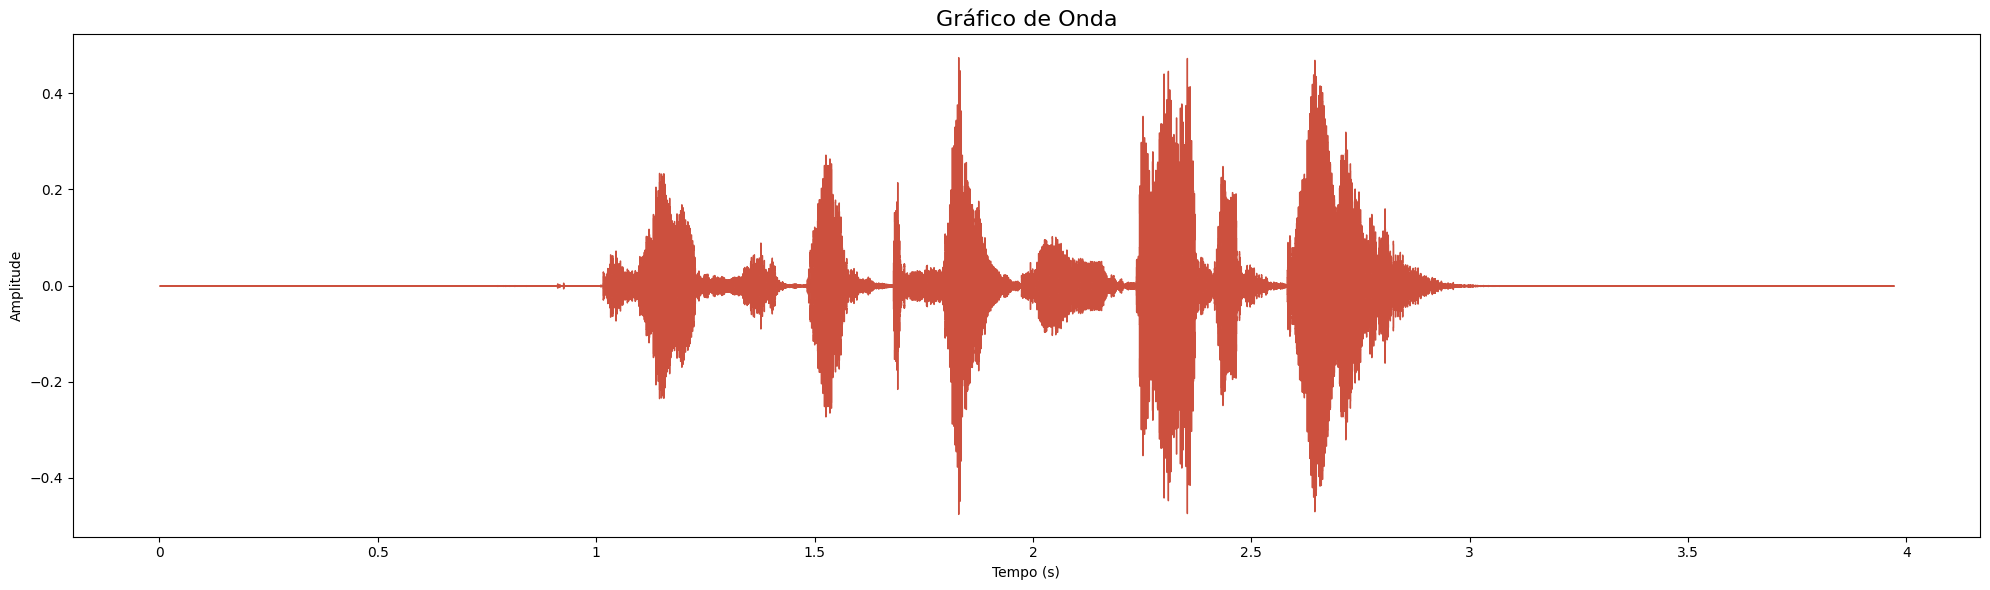

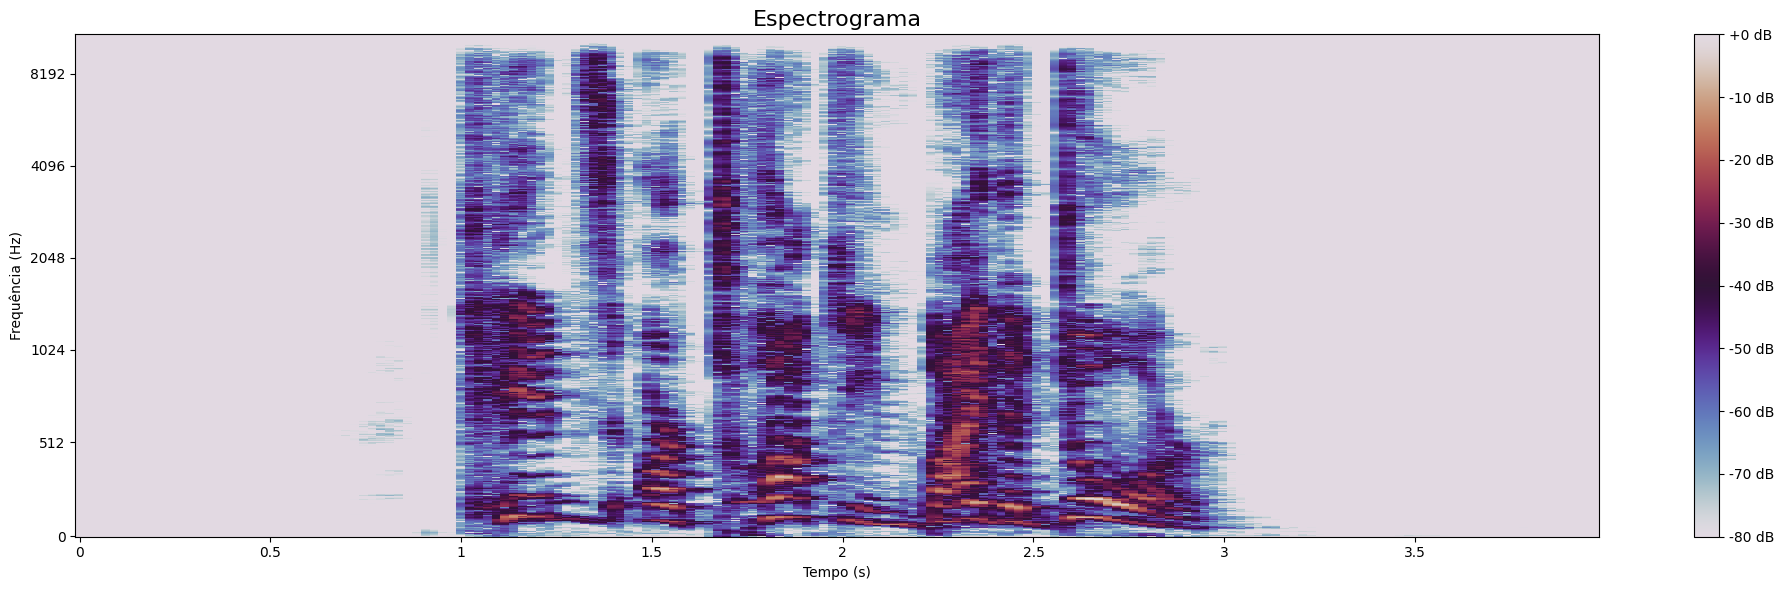

In [90]:
emotion='angry'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

Audio(path)

#### - Emoção de Medo

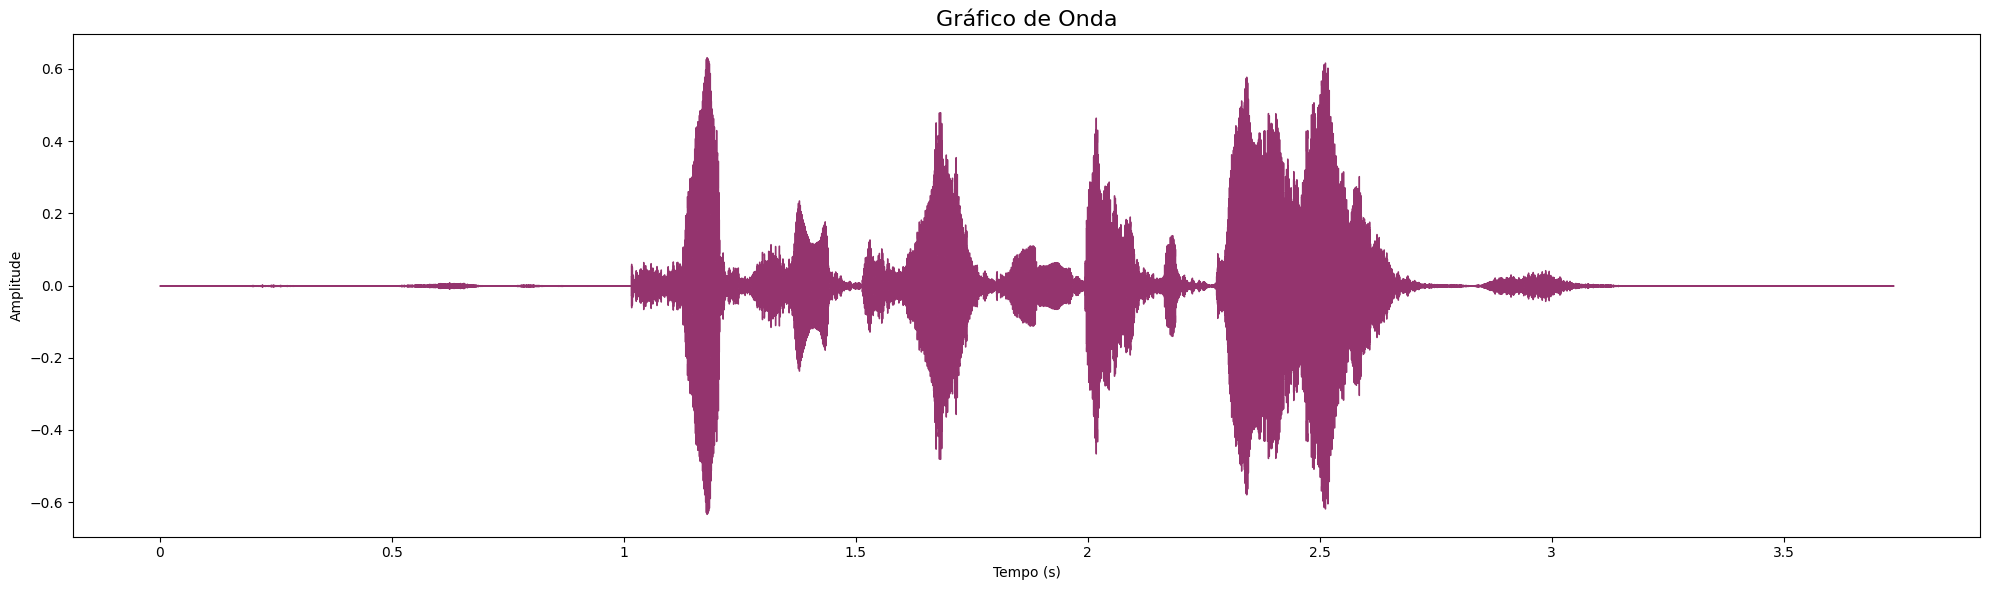

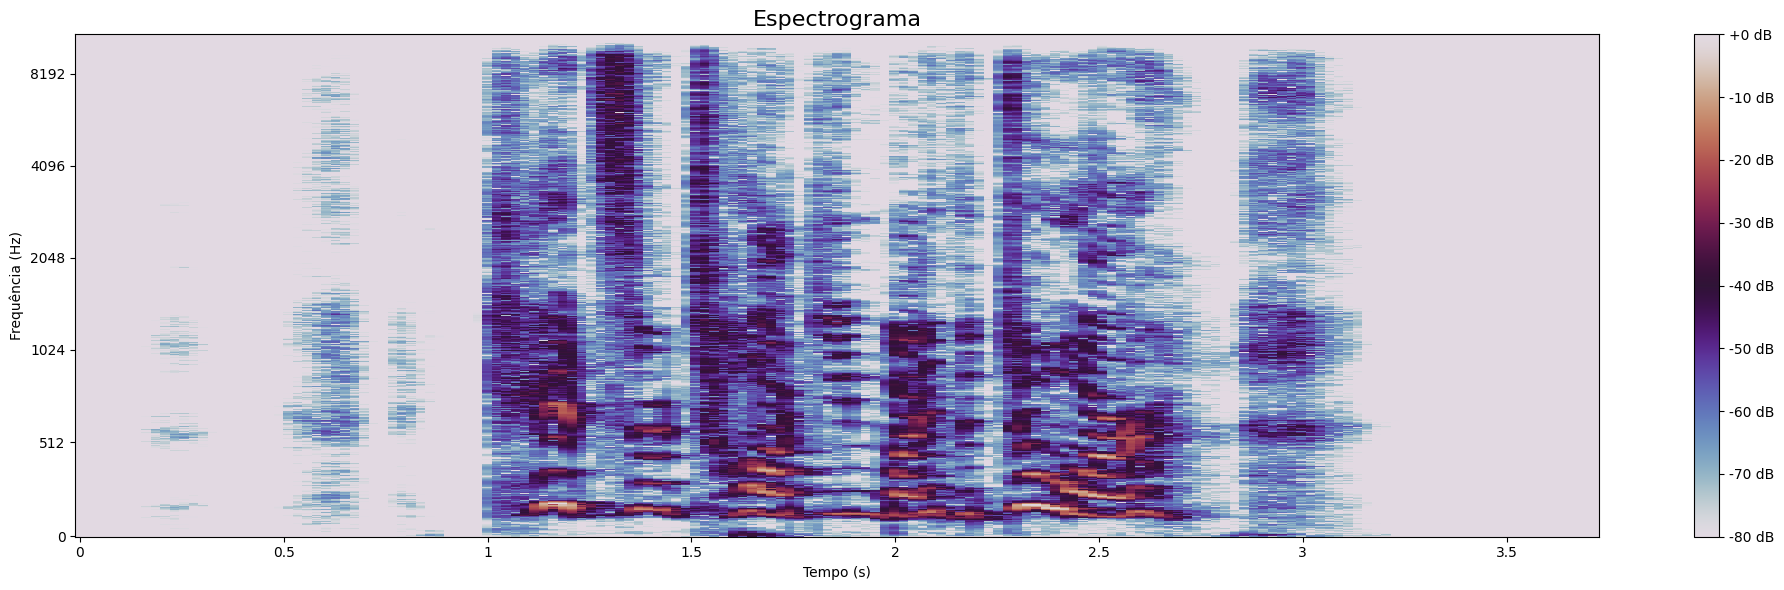

In [91]:
emotion='fear'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### - Emoção de Nojo

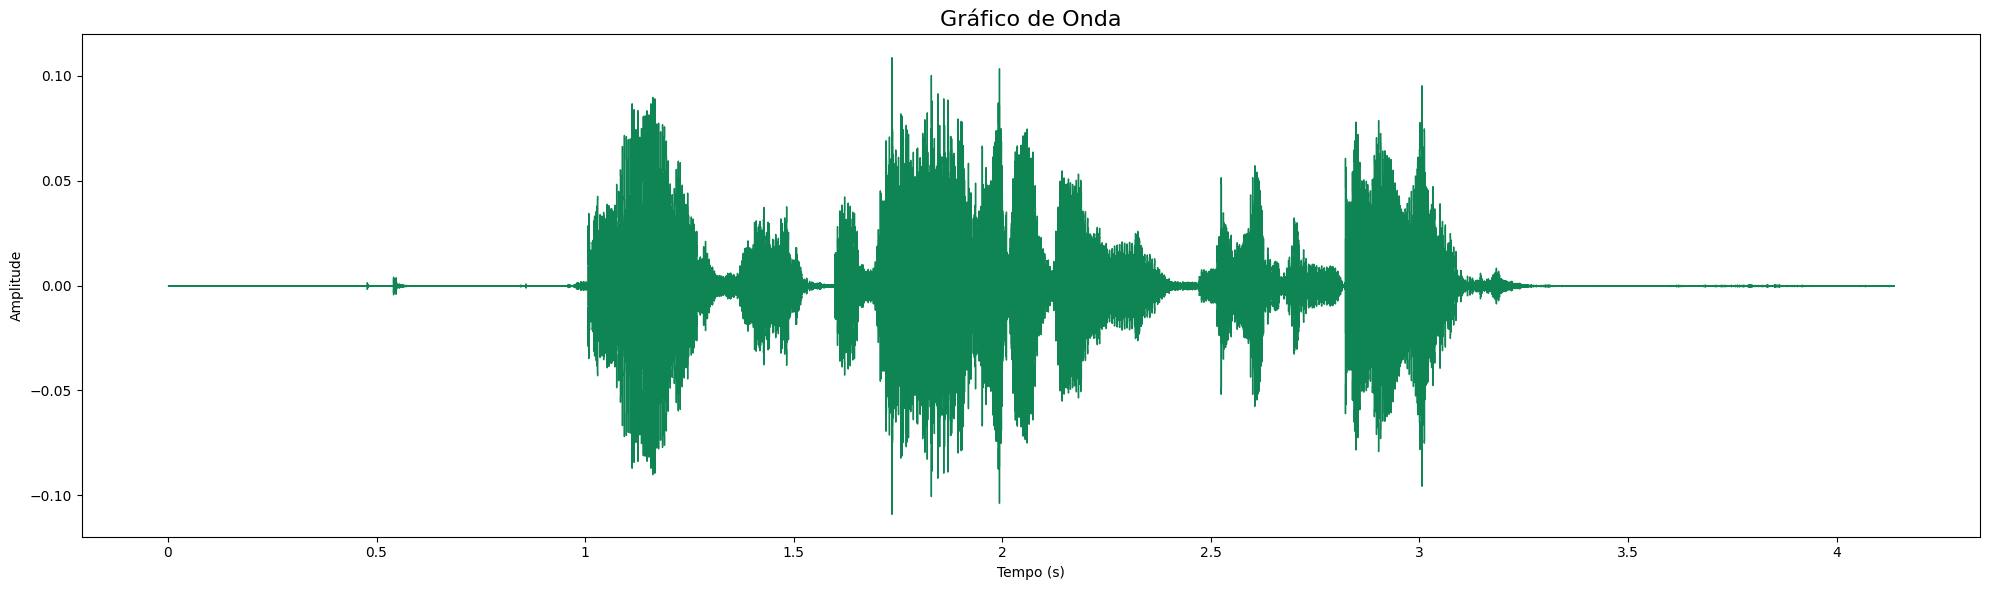

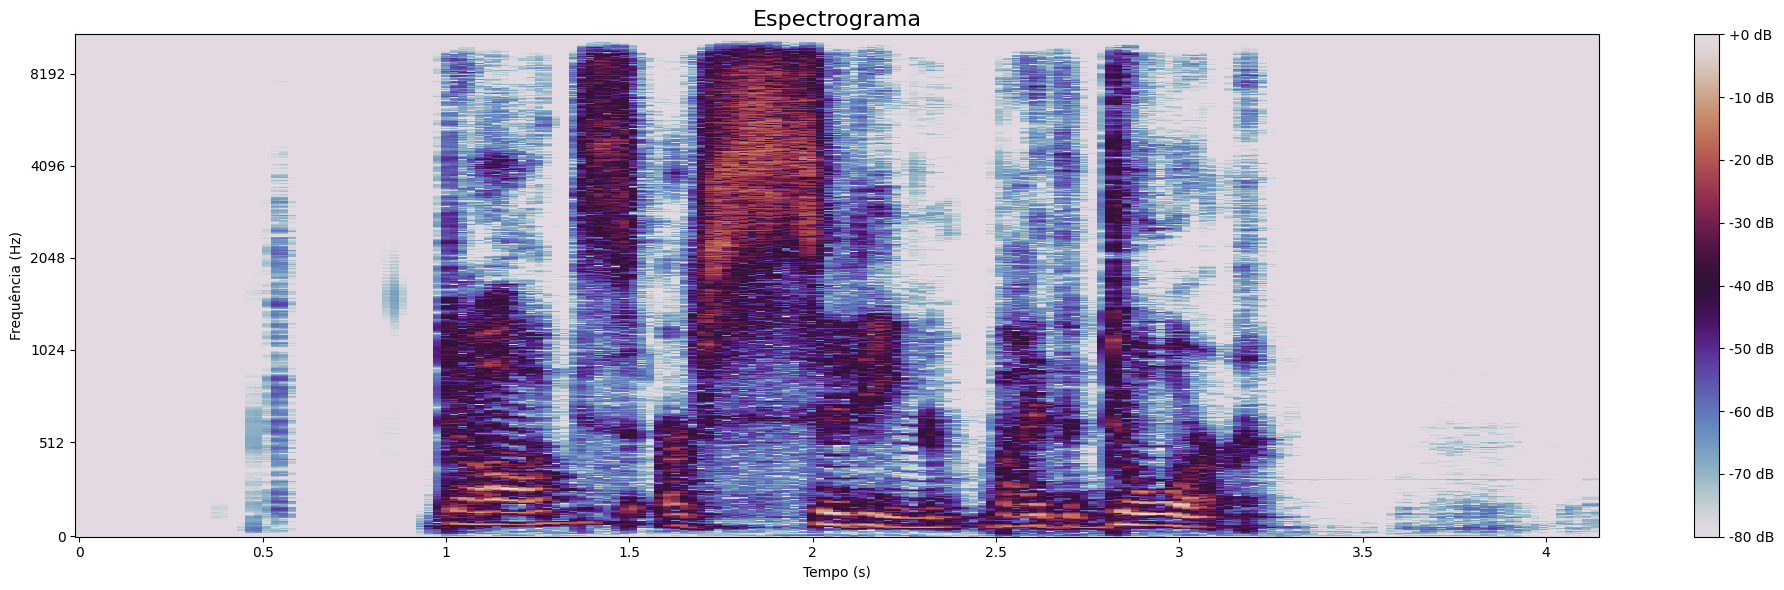

In [92]:
emotion='disgust'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### - Emoção de Tristeza

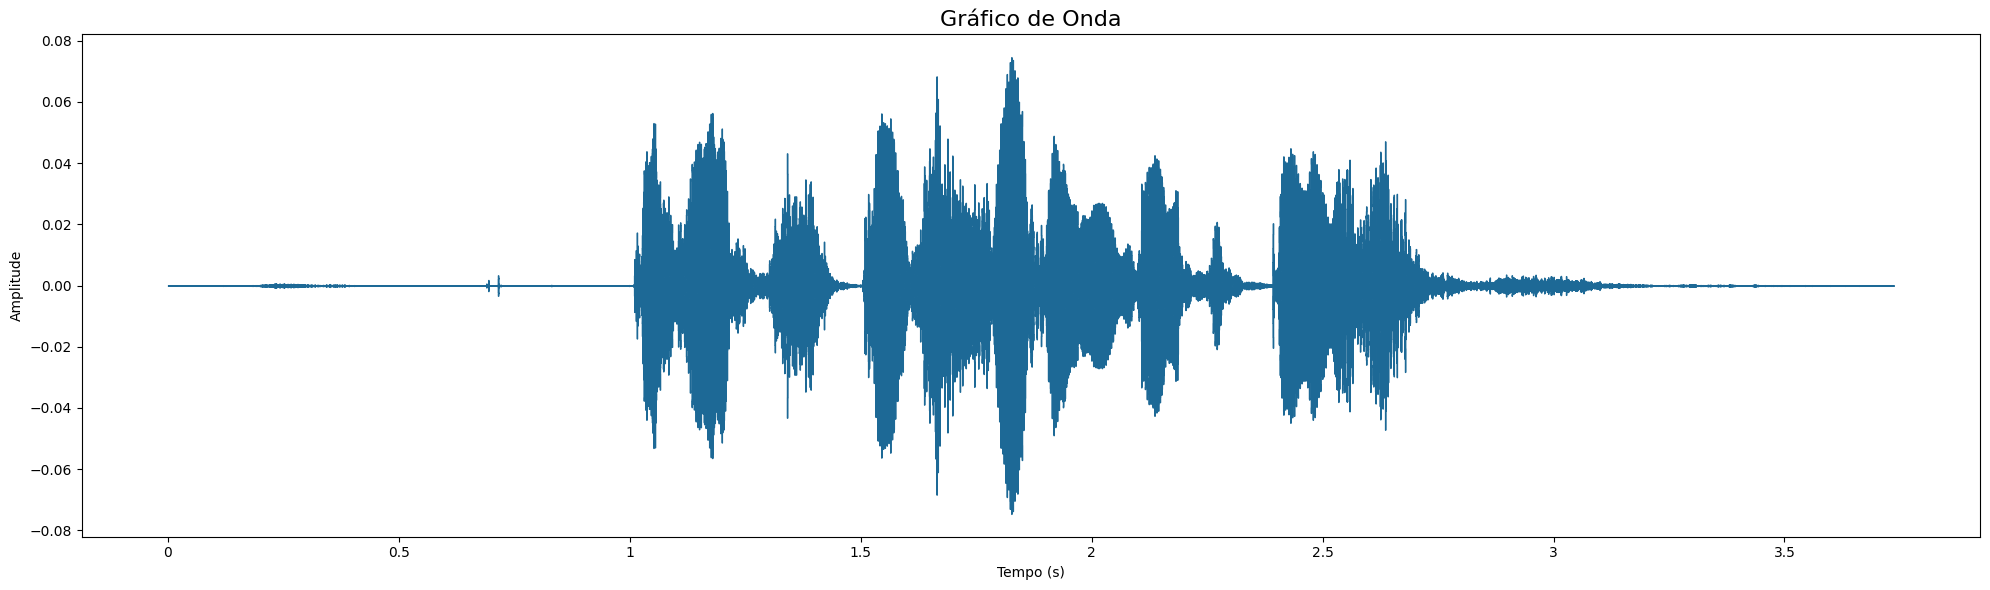

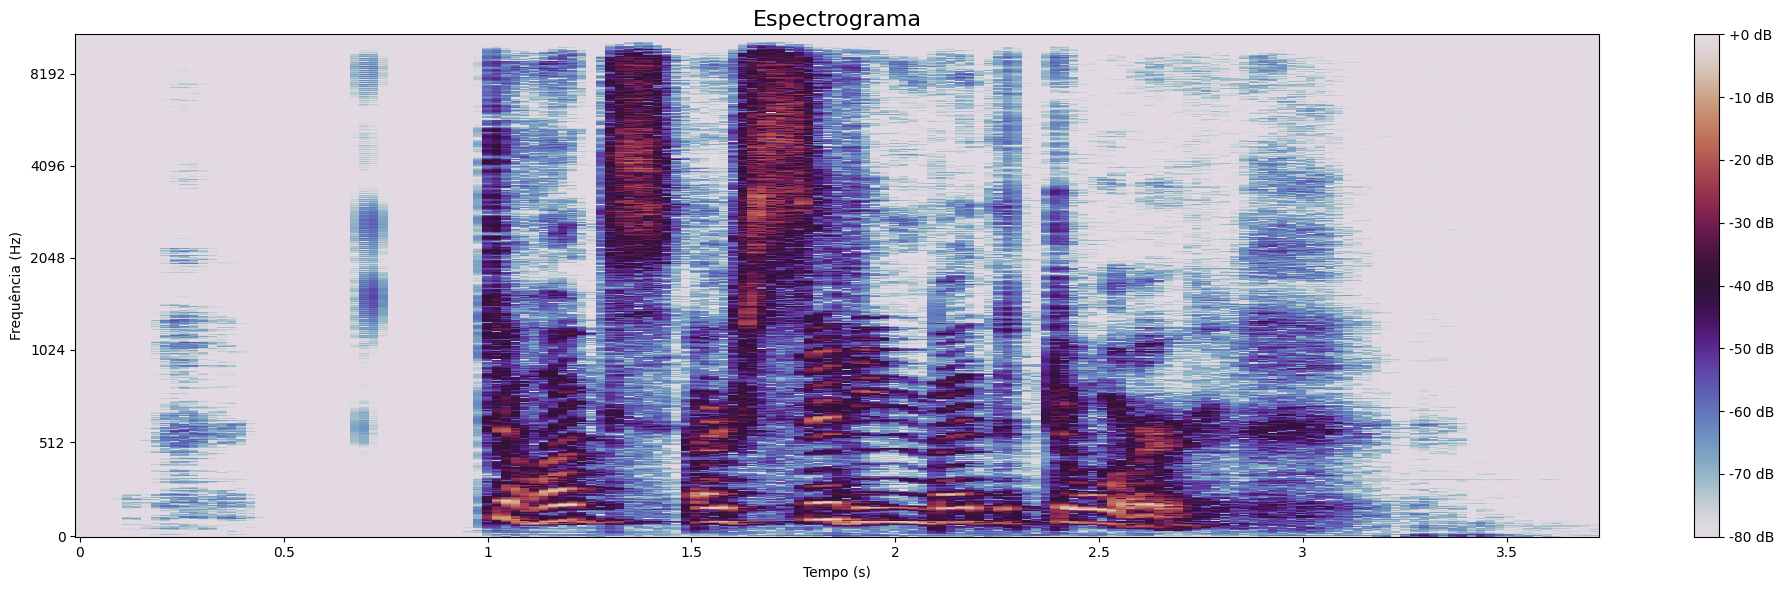

In [93]:
emotion='sad'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### - Emoção de Surpresa

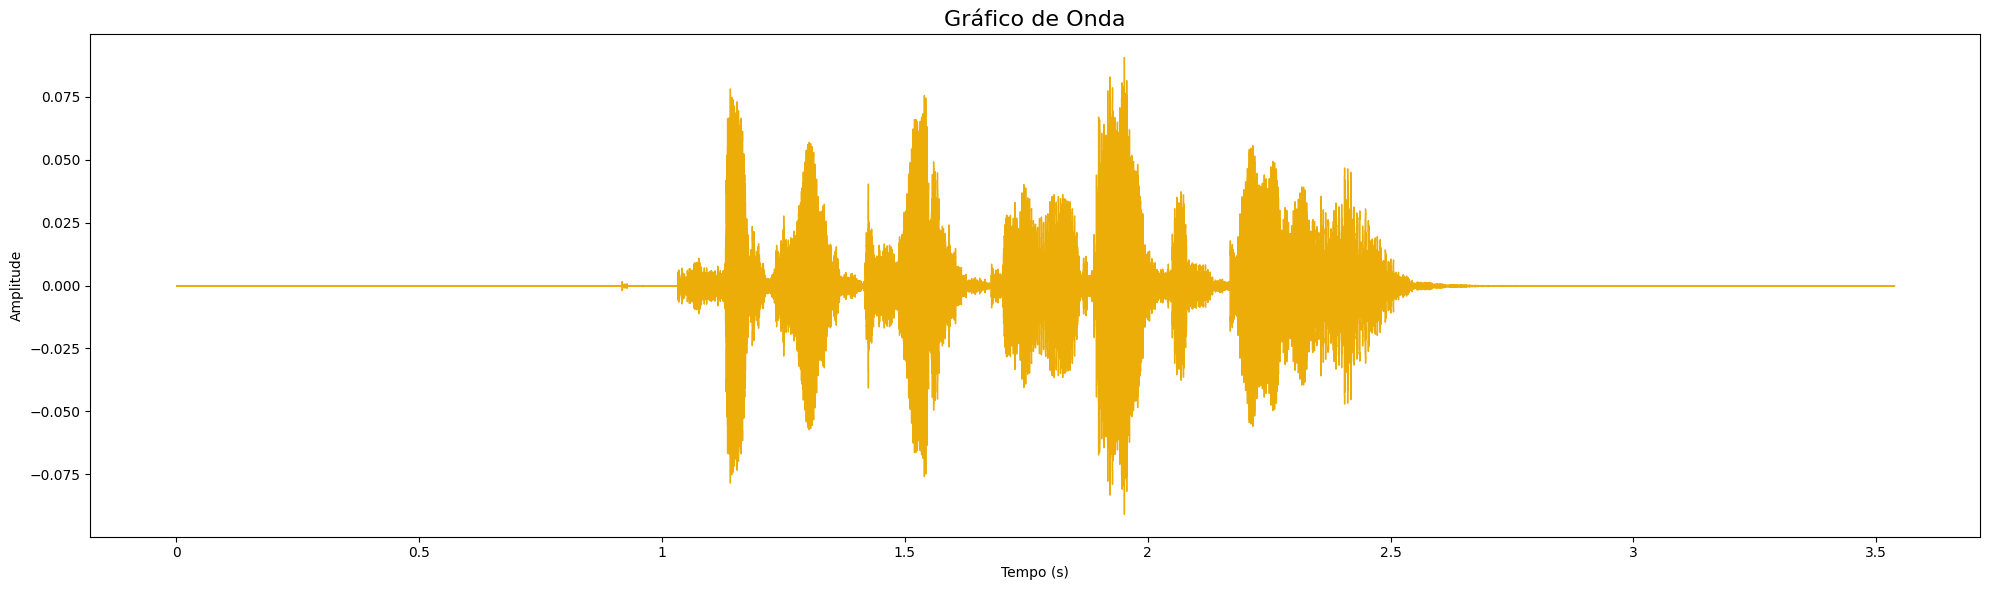

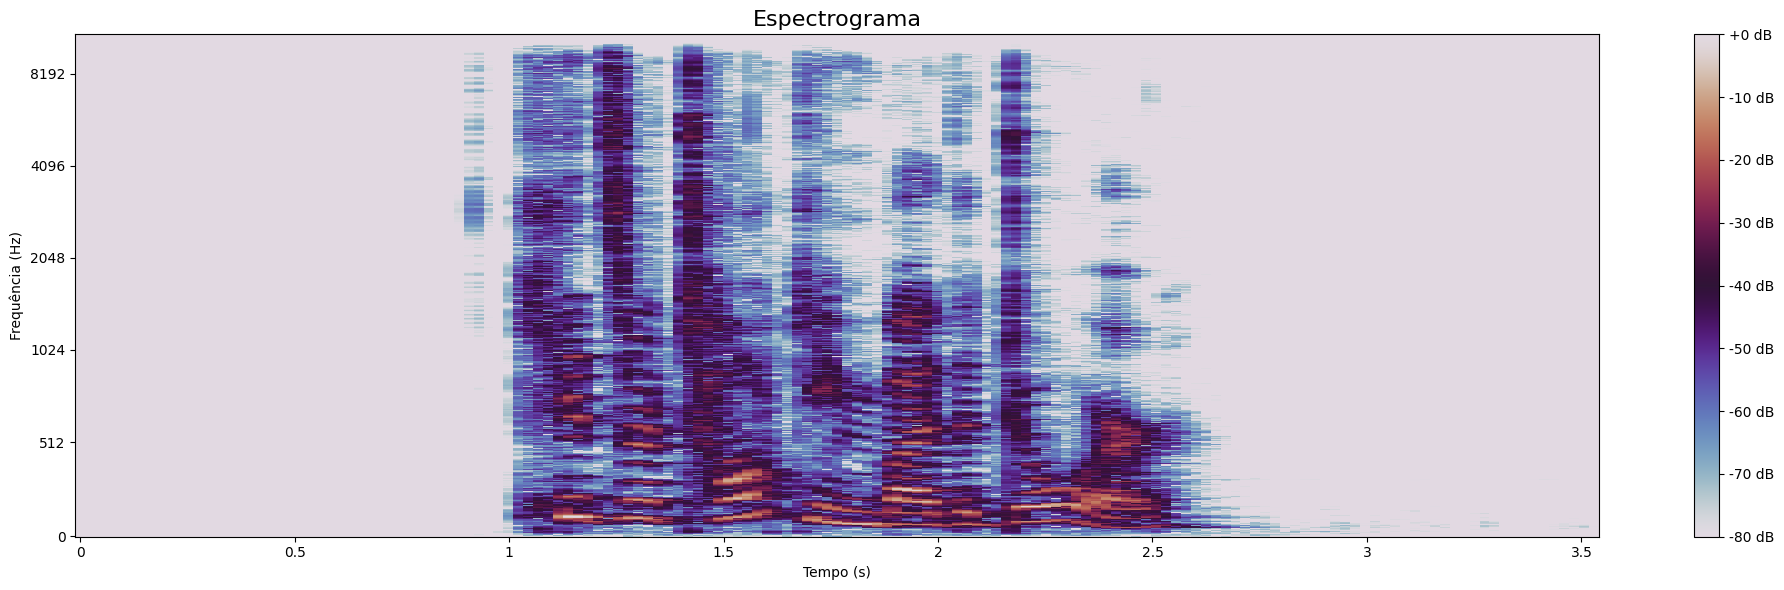

In [94]:
emotion='surprise'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### - Emoção de Felicidade

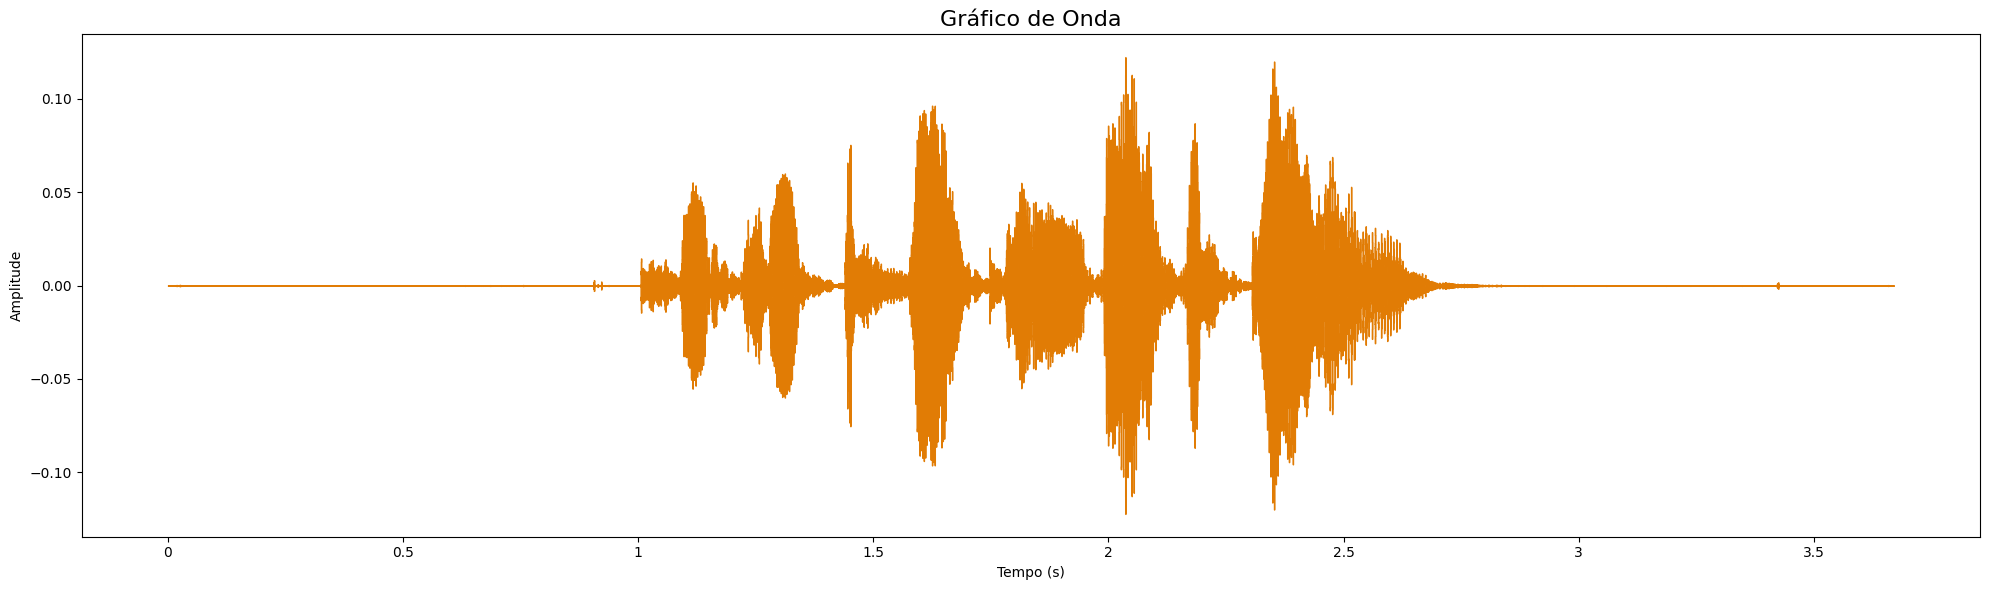

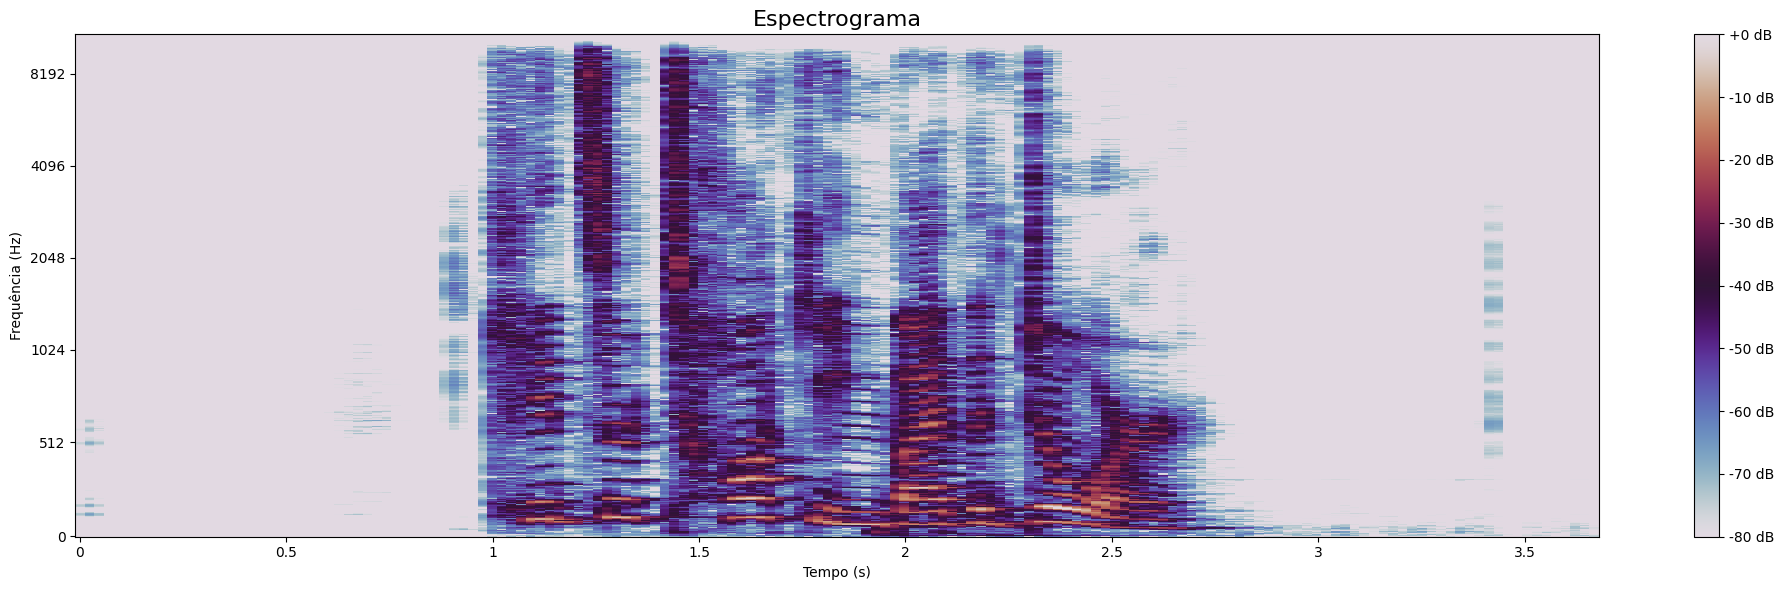

In [95]:
emotion='happy'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### - Emoção Calma

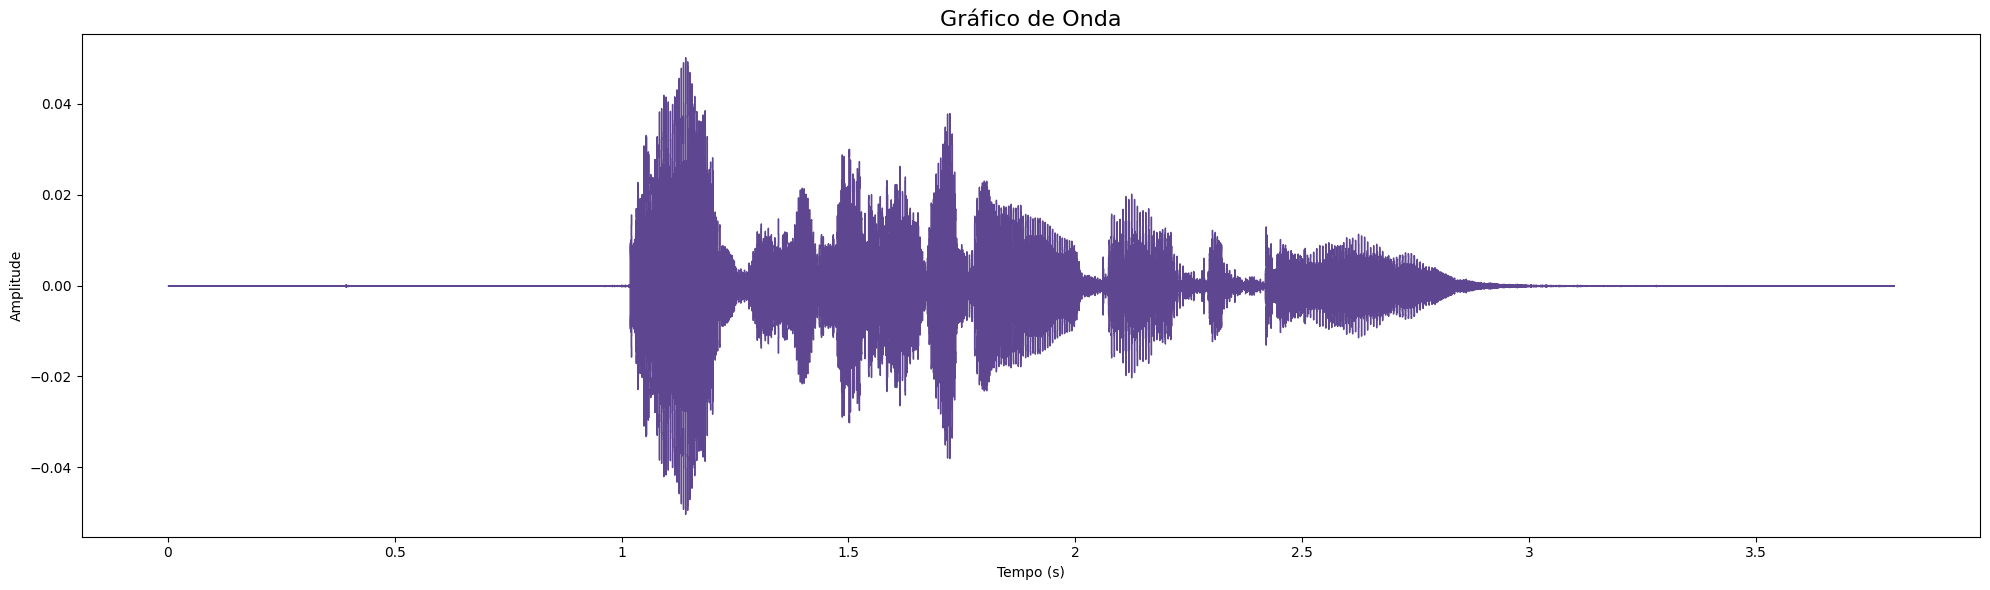

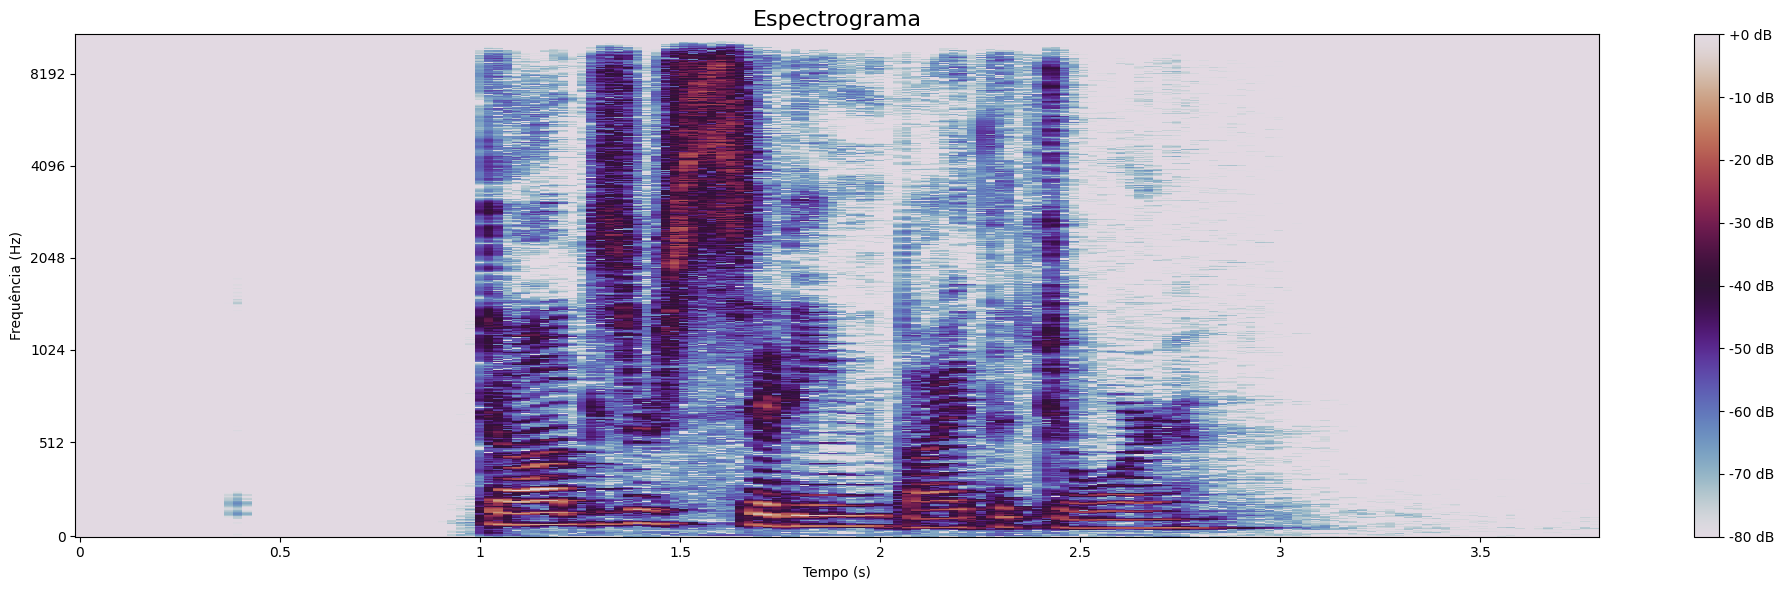

In [96]:
emotion='calm'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### - Emoção Neutra

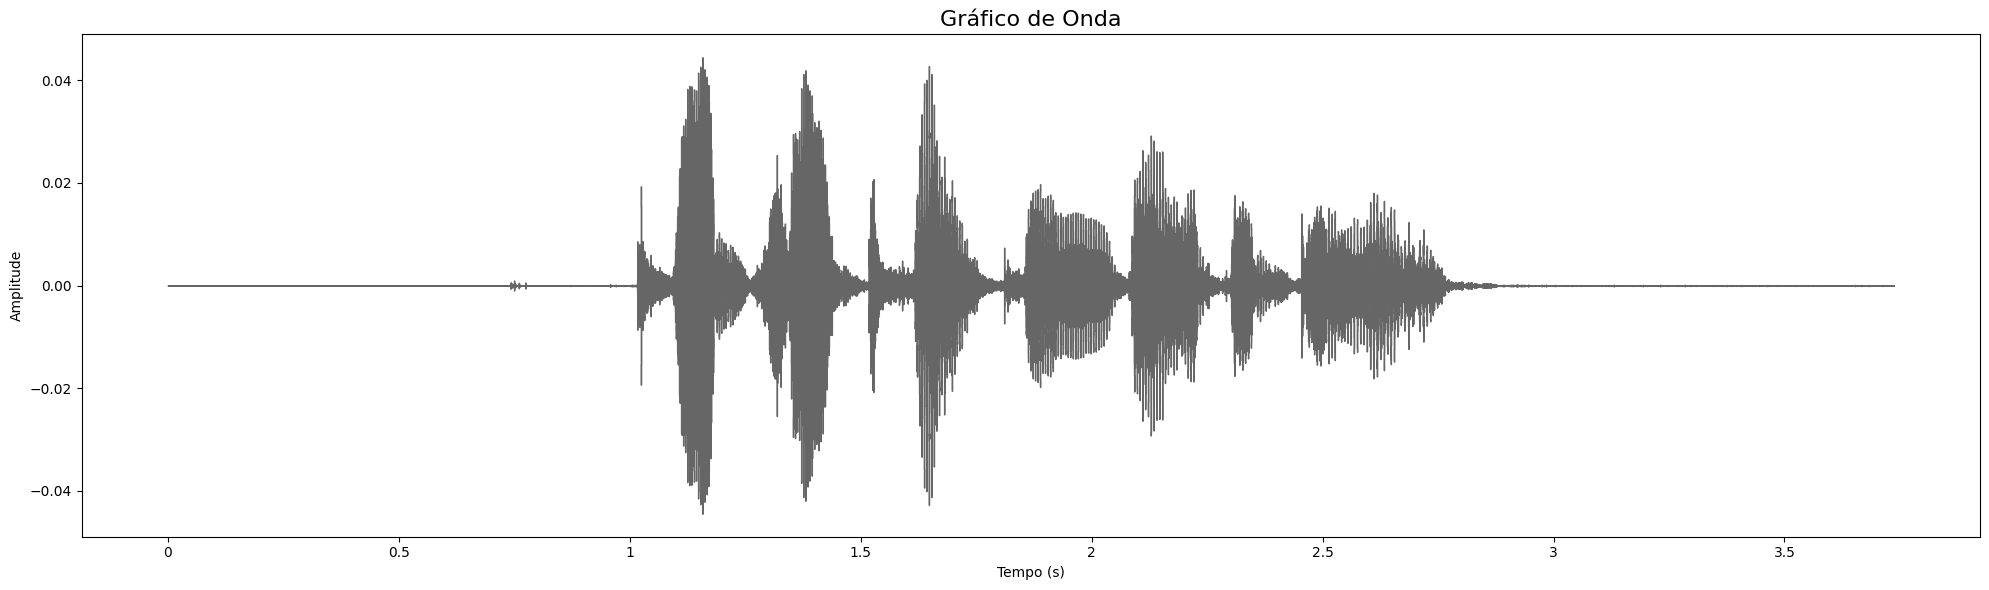

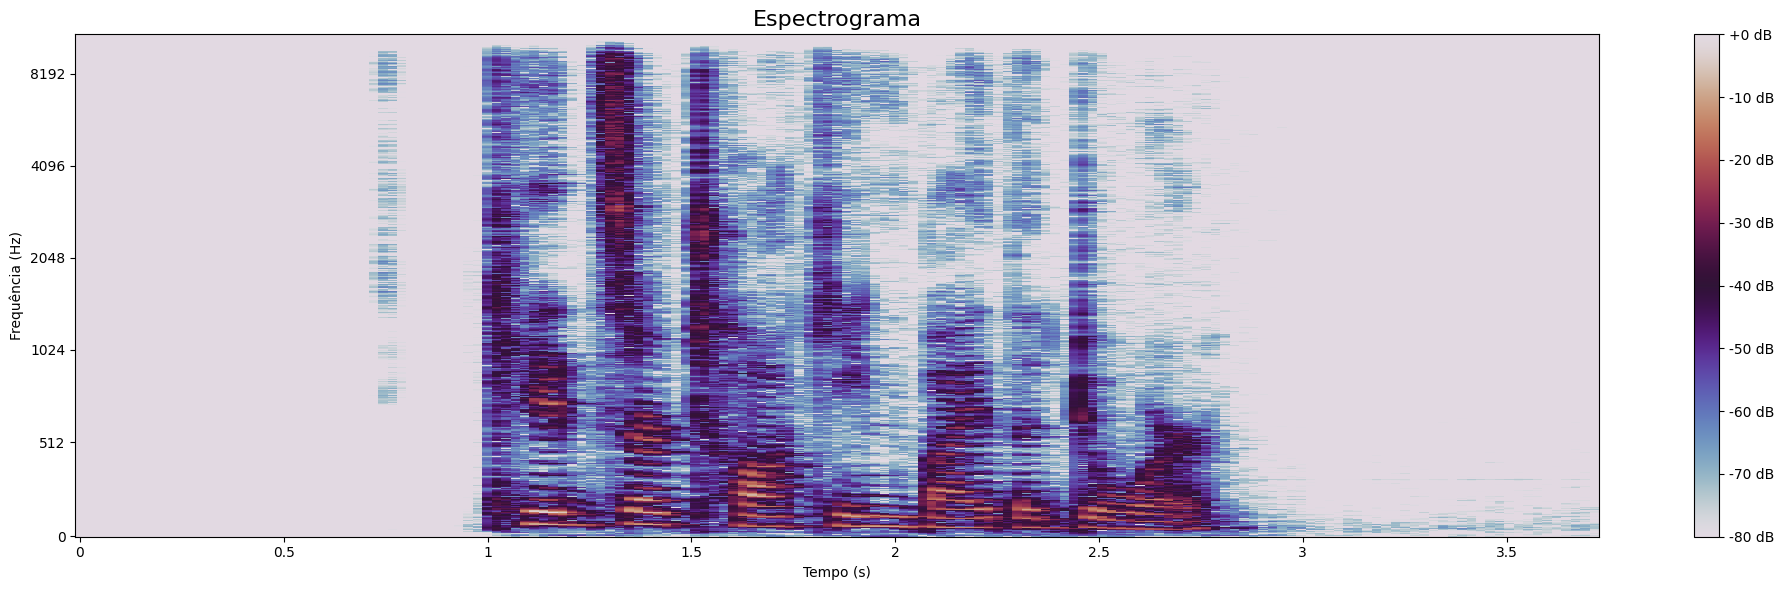

In [97]:
emotion='neutral'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### 4.3. Análise da duração dos áudios

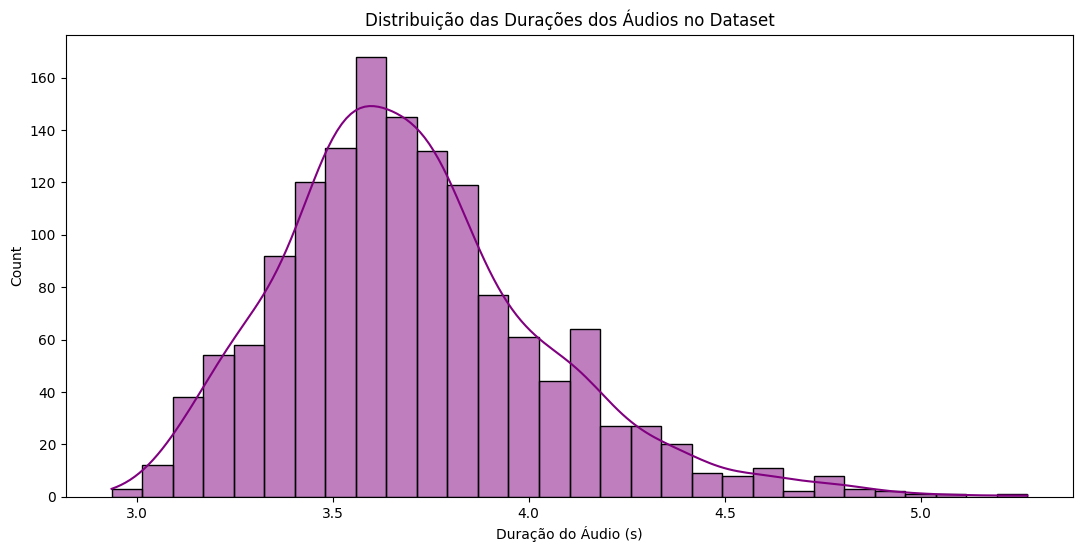

In [98]:
durations = [] # Criando lista que armazena a duração de cada áudio.
for path in Ravdess_df['Path']:
    audio, sr = librosa.load(path, sr=None) 
    durations.append(librosa.get_duration(y=audio, sr=sr))

audio_duration = pd.DataFrame(durations, columns=['Duration'])

plt.figure(figsize=(13,6))
sns.histplot(data=audio_duration, x='Duration', bins=30, kde=True, color='purple')
plt.title('Distribuição das Durações dos Áudios no Dataset')
plt.xlabel('Duração do Áudio (s)')
plt.show() # Plotando gráfico de duração dos áudios.

### 5. Aumento de Dados (Data Augmentation)
- O aumento de dados é o processo pelo qual criamos novas amostras sintéticas de dados adicionando pequenas perturbações ao nosso conjunto de treinamento original.
- Para gerar dados sintéticos para áudio, podemos aplicar injeção de ruído, deslocamento no tempo, alteração de tom (pitch) e velocidade.
- O objetivo é tornar nosso modelo invariante a essas perturbações e melhorar sua capacidade de generalização.
- Para que isso funcione, as perturbações adicionadas devem manter o mesmo rótulo da amostra de treinamento original.
- No caso de imagens, o aumento de dados pode ser realizado por meio de deslocamento, zoom, rotação, entre outras técnicas.

Agora, vamos verificar quais técnicas de aumento de dados funcionam melhor para o nosso conjunto de dados :)

In [99]:
def noise(data): # Adicionando ruído aos áudios:
    noise_amp = 0.005 * np.max(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def stretch(data, rate=0.8): # Mudando a velocidade dos áudios:
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data): # Mudando a posição dos áudios:
    shift_range = np.random.randint(low=-5, high=5) * 500
    return np.roll(data, shift=shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7): # Mudando o tom dos áudios:
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

#### 5.1. Simple Audio

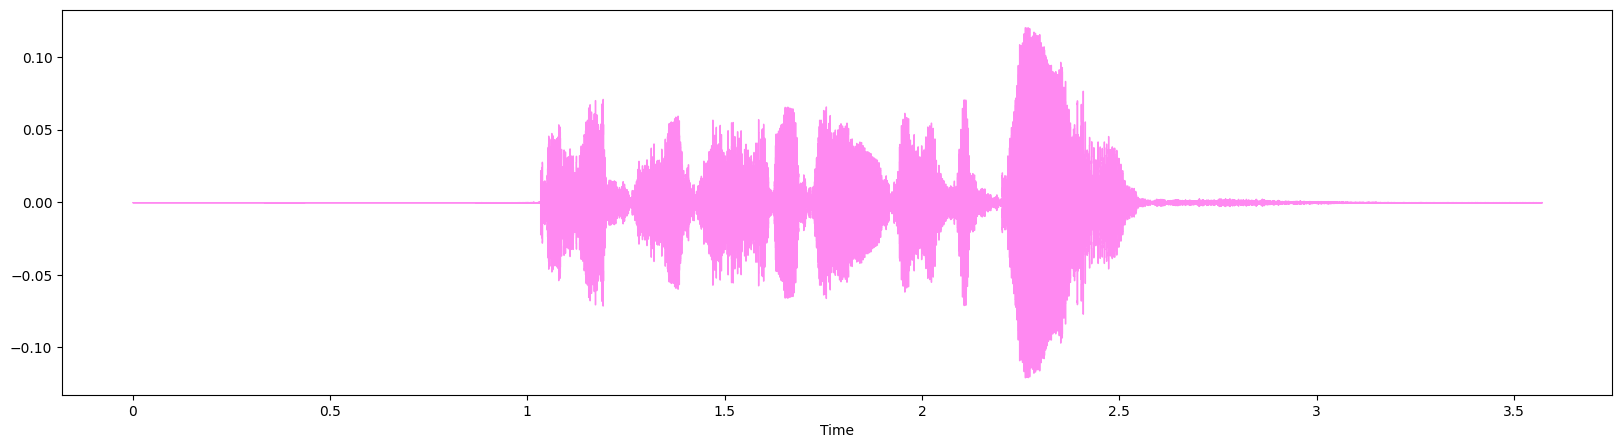

In [100]:
plt.figure(figsize=(20, 5))
librosa.display.waveshow(y=data, sr=sample_rate, color="#ff89f1")
Audio(path)

#### 5.2. Noise Injection (Injeção de ruído)

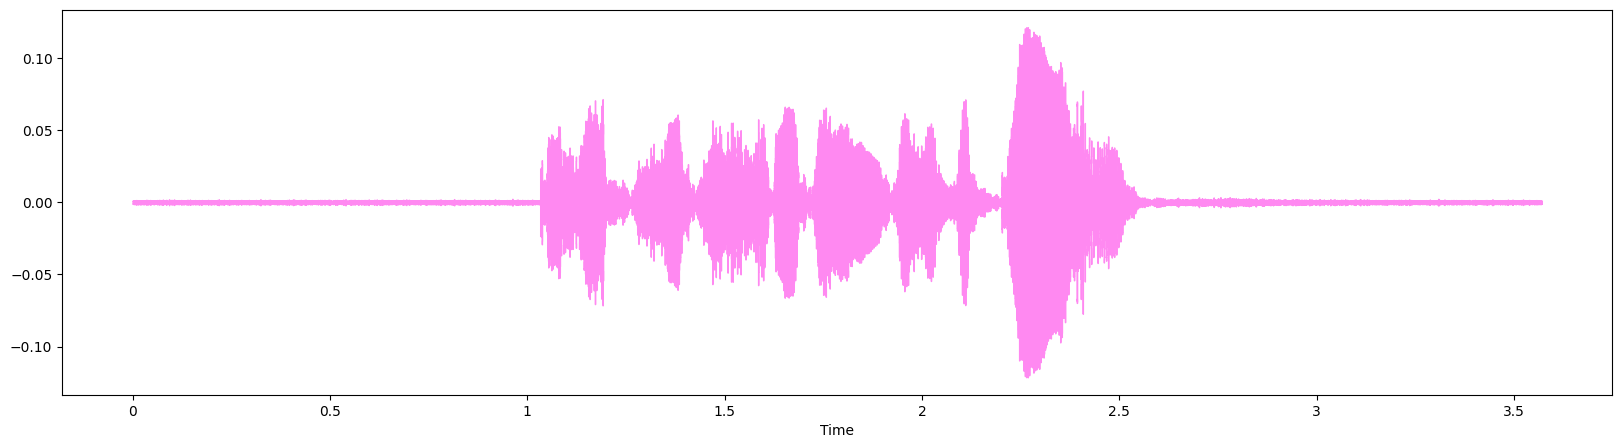

In [101]:
x = noise(data)
plt.figure(figsize=(20, 5))
librosa.display.waveshow(y=x, sr=sample_rate, color="#ff89f1")
Audio(x, rate=sample_rate)

#### 5.3. Stretching (Alongamento)
- Mudando a velocidade do aúdio

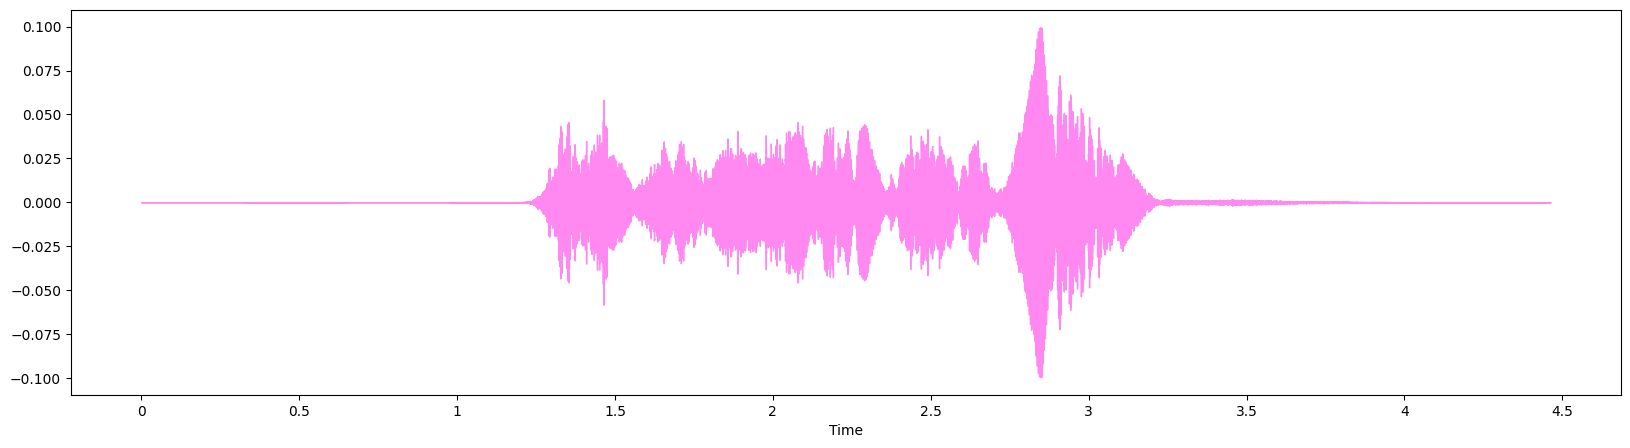

In [102]:
x = stretch(data)
plt.figure(figsize=(20, 5))
librosa.display.waveshow(y=x, sr=sample_rate, color="#ff89f1")
Audio(x, rate=sample_rate)

#### 5.4. Shifting (Deslocamento)
- Estou deslocando o sinal de áudio no tempo

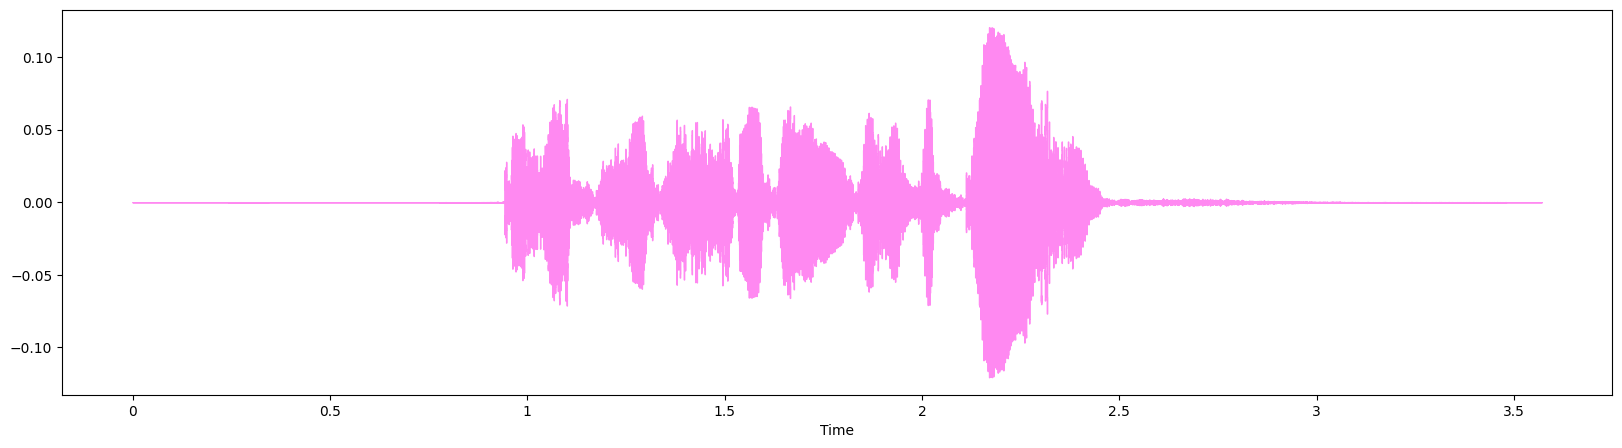

In [103]:
x = shift(data)
plt.figure(figsize=(20, 5))
librosa.display.waveshow(y=x, sr=sample_rate, color="#ff89f1")
Audio(x, rate=sample_rate)

#### 5.5. Pitch (Tom)

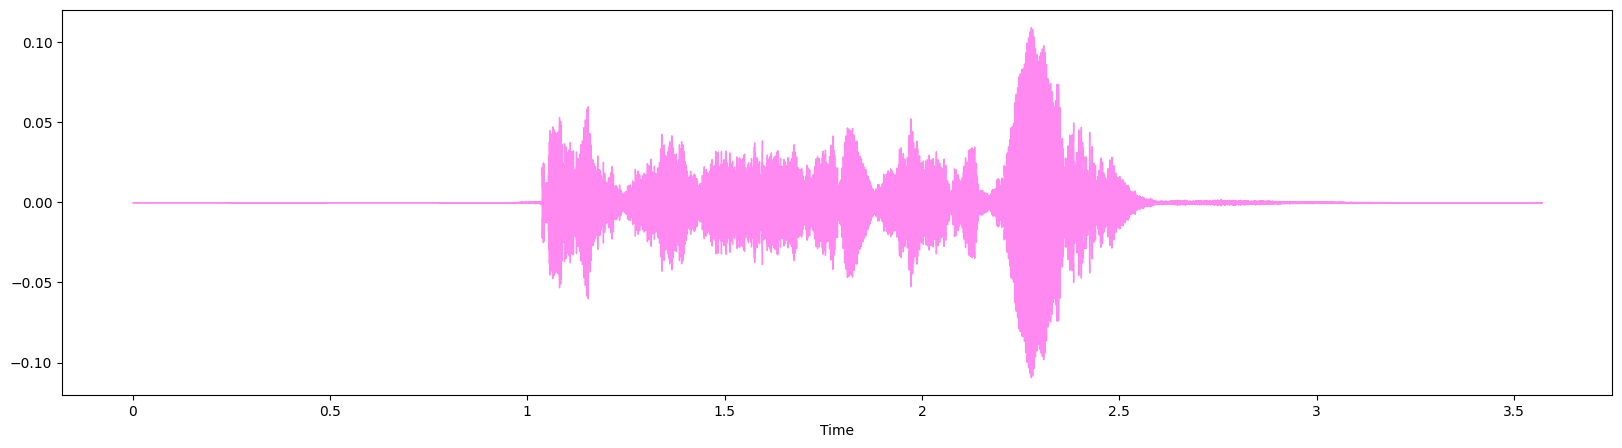

In [104]:
x = pitch(data, sample_rate)
plt.figure(figsize=(20, 5))
librosa.display.waveshow(y=x, sr=sample_rate, color="#ff89f1")
Audio(x, rate=sample_rate)

### 6. Preparando o dataframe para a extração das features

#### 6.1. Função para Padronizar Áudios

In [105]:
import soundfile as sf 

def preprocess_and_save_audio(input_path, output_dir, target_sr=16000):
    """
    Padroniza e salva os arquivos de áudio.
    
    Args:
    - input_path (str): Caminho do arquivo de entrada.
    - output_dir (str): Diretório para salvar o arquivo processado.
    - target_sr (int): Taxa de amostragem desejada (default: 16000).
    
    Retorna:
    - str: Caminho do arquivo processado.
    """
    os.makedirs(output_dir, exist_ok=True)
    try: 
        audio, sr = librosa.load(input_path, sr=target_sr, mono=True)

        filename = os.path.basename(input_path)
        output_path = os.path.join(output_dir, filename)

        sf.write(output_path, audio, target_sr)
        
        return output_path
    except Exception as e: 
        print(f"Erro ao processar {input_path}: {e}")
        return None

#### 6.2. Aplicar a Padronização a Todos os Áudios

In [106]:
processed_audio_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed_audio")

os.makedirs(processed_audio_dir, exist_ok=True)

print(f"Os arquivos serão salvos em: {processed_audio_dir}")


Ravdess_df["Processed_Path"] = Ravdess_df["Path"].apply(
    lambda x: preprocess_and_save_audio(x, processed_audio_dir)
)

Ravdess_df = Ravdess_df[Ravdess_df["Processed_Path"].notnull()]

Os arquivos serão salvos em: /Users/iza/Desktop/miniprojeto2/data/processed_audio


#### 6.3. Salvar o DataFrame Final

In [107]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
os.makedirs(data_dir, exist_ok=True)

csv_path = os.path.join(data_dir, "ravdess_preprocessed.csv")

Ravdess_df.to_csv(csv_path, index=False)

print(f"O arquivo foi salvo em: {csv_path}")


O arquivo foi salvo em: /Users/iza/Desktop/miniprojeto2/data/ravdess_preprocessed.csv


### Isso é tudo por aqui, você fez um ótimo trabalho e está indo muito bem!
#### Estamos prontos para o pŕoximo notebook, mas antes vamos ver as coisas que aprendemos até então:
- Criamos o dataframe (você mudou o path e entendeu a cara do nosso dataframe)
- Limpamos os dados (verificamos se existiam aúdios corrompidos)
- Plotamos gráficos (fizemos uns gráficos bem bonitos sobre o dataframe)
- Data augmentation (aplicamos algumas funções no aúdio para aumentar a quantidade de dados)
- Salvamos um dataframe com pandas (usamos to_csv)